# World Bank Home Ownership

This notebook contains code developed to query World Bank data on country poverty and income disparity. It also develops code necessary for plotly visualizations.  

## Data
The data can be found at: 
- Poverty rates: https://databank.worldbank.org/data/reports.aspx?source=2&series=SI.POV.NAGP
- Lowest 10% income share: https://databank.worldbank.org/data/reports.aspx?source=2&series=SI.DST.FRST.10
- Highest 10% income share: https://databank.worldbank.org/data/reports.aspx?source=2&series=SI.DST.10TH.10

## Gather

In [51]:
import json
import requests
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline

Let's create a function to complete the API query.

In [2]:
# Define query function
def api_query(data_code, params):
    link = 'https://api.worldbank.org/v2/en/country/all/indicator/'
    r = requests.get(link + data_code, params=params)
    return r.json()

In [55]:
# Set up request parameters
params = {'format': 'json', 'per_page': '1000', 'date': '1990:2017'}

In [4]:
poverty = api_query('SI.POV.NAGP', params)

In [6]:
# Get results details
poverty[0]

{'page': 1,
 'pages': 7,
 'per_page': 1000,
 'total': 6864,
 'sourceid': '2',
 'lastupdated': '2019-01-30'}

There are 7 pages of results that contain 6,864 records.

In [15]:
poverty[1][0]

{'indicator': {'id': 'SI.POV.NAGP',
  'value': 'Poverty gap at national poverty lines (%)'},
 'country': {'id': '1A', 'value': 'Arab World'},
 'countryiso3code': '',
 'date': '2015',
 'value': None,
 'unit': '',
 'obs_status': '',
 'decimal': 1}

The keys I want are `country['id']`, `country['value']`, `date`, `value`. With this information I can create a function that programmatically obtains the full number of pages, queries each and saves them. 

In [29]:
def full_query(data_code, params, folder_name):
    # Complete initial query
    initial = api_query(data_code, params)
    
    # Determine number of pages for full results
    num_pages = initial[0]['pages']
    
    # Create data directory
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    for i in range(num_pages):
        # Save file
        file_name = data_code + '_pg_' + str(i + 1) + '.txt'
        file_path = os.path.join(folder_name, file_name)
        if not os.path.isfile(file_path):
            open(file_path, 'w').close()
        
        # Update params
        params['page'] = i + 1
        
        # Complete query and save
        results = api_query(data_code, params)
        with open(file_path, 'w') as file:
            json.dump(results, file)

In [56]:
full_query('SI.POV.NAGP', params, 'data')

Now I need to create a function to extract the data. I've saved each of the pages as separate files so I will need to collect all of them.

In [13]:
df_list = []
    
directory = os.fsencode('data')
for file in os.listdir(directory):
    file_name = os.fsdecode(file)
    if file_name.endswith(".txt"):
        try
        print(file_name)
        file_path = os.path.join('data', file_name)

country_map.txt
SI.POV.NAGP_pg_1.txt
SI.POV.NAGP_pg_2.txt
SI.POV.NAGP_pg_3.txt
SI.POV.NAGP_pg_4.txt
SI.POV.NAGP_pg_5.txt
SI.POV.NAGP_pg_6.txt
SI.POV.NAGP_pg_7.txt
SI.POV.NAGP_pg_8.txt


In [18]:
def extract_data(folder_name):
    """
    Creates a dataframe from the .txt files in the specified folder. 
    Files are originally extracted from the World Bank Data API.
    """
    df_list = []
    
    directory = os.fsencode(folder_name)
    for file in os.listdir(directory):
        file_name = os.fsdecode(file)
        if file_name.endswith(".txt"):
            try:
                file_path = os.path.join(folder_name, file_name)
                with open(file_path) as json_file:
                    data = json.load(json_file)
                    for entry in data[1]:
                        df_list.append({
                            'country': entry['country']['value'],
                            'code': entry['country']['id'],
                            'year': entry['date'],
                            'value': entry['value']
                        })
            # Ignore non-JSON files
            except:
                continue
    
    df = pd.DataFrame(df_list, columns=['country', 'code',
                                        'year', 'value'])
    
    return df

Let's explore the poverty level data.

In [20]:
df = extract_data('data')
df.head()

,country,code,year,value
0,Arab World,1A,2017,NaN
1,Arab World,1A,2016,NaN
2,Arab World,1A,2015,NaN
3,Arab World,1A,2014,NaN
4,Arab World,1A,2013,NaN


In [60]:
df.shape

(7392, 4)

There are 7,392 rows and 4 columns in the dataset.

Let's look at the unique country codes.

In [61]:
df.country_id.unique()

array(['1A', 'S3', 'B8', 'V2', 'Z4', '4E', 'T4', 'XC', 'Z7', '7E', 'T7',
       'EU', 'F1', 'XE', 'XD', 'XF', 'ZT', 'XH', 'XI', 'XG', 'V3', 'ZJ',
       'XJ', 'T2', 'XL', 'XO', 'XM', 'XN', 'ZQ', 'XQ', 'T3', 'XP', 'XU',
       'XY', 'OE', 'S4', 'S2', 'V4', 'V1', 'S1', '8S', 'T5', 'ZG', 'ZF',
       'T6', 'XT', '1W', 'AF', 'AL', 'DZ', 'AS', 'AD', 'AO', 'AG', 'AR',
       'AM', 'AW', 'AU', 'AT', 'AZ', 'BS', 'BH', 'BD', 'BB', 'BY', 'BE',
       'BZ', 'BJ', 'BM', 'BT', 'BO', 'BA', 'BW', 'BR', 'VG', 'BN', 'BG',
       'BF', 'BI', 'CV', 'KH', 'CM', 'CA', 'KY', 'CF', 'TD', 'JG', 'CL',
       'CN', 'CO', 'KM', 'CD', 'CG', 'CR', 'CI', 'HR', 'CU', 'CW', 'CY',
       'CZ', 'DK', 'DJ', 'DM', 'DO', 'EC', 'EG', 'SV', 'GQ', 'ER', 'EE',
       'SZ', 'ET', 'FO', 'FJ', 'FI', 'FR', 'PF', 'GA', 'GM', 'GE', 'DE',
       'GH', 'GI', 'GR', 'GL', 'GD', 'GU', 'GT', 'GN', 'GW', 'GY', 'HT',
       'HN', 'HK', 'HU', 'IS', 'IN', 'ID', 'IR', 'IQ', 'IE', 'IM', 'IL',
       'IT', 'JM', 'JP', 'JO', 'KZ', 'KE', 'KI', 'K

These are not currently interpretable, but we have the country names.

Let's have a look at how many rows have missing data.

In [21]:
df[df.isnull().sum(axis=1) > 0].shape

(7089, 4)

Out of 7,392 rows 7,089 have at least one column of missing data - that's a lot! Which countries have no missing data?

In [22]:
no_missing = df[df.isnull().sum(axis=1) == 0]

In [24]:
no_missing.groupby('country')['country'].count().sort_values(ascending=False)

country
Kazakhstan                  15
Russian Federation          14
Honduras                    14
Bolivia                     14
Indonesia                   12
Uruguay                     10
Peru                         9
Montenegro                   9
Kyrgyz Republic              9
Ecuador                      9
Moldova                      9
Armenia                      7
Uganda                       7
Cambodia                     7
Costa Rica                   6
Colombia                     6
Philippines                  4
Cameroon                     4
Lao PDR                      4
Mongolia                     4
Ethiopia                     4
Sri Lanka                    4
Guinea                       4
Albania                      4
Mauritania                   3
Malaysia                     3
Mexico                       3
Lesotho                      3
Malawi                       3
India                        3
                            ..
Jordan                       2


What is the total number of years for which a country could have records?

In [28]:
df['year'] = df['year'].astype(str)
df['year'].astype(int).max() - df['year'].astype(int).min()

27

No country has data for every year. It's also not even the most developed countries that have the least data points. Let's explore if there are countries or years that have more data.

What years have the most data?

In [66]:
no_missing.groupby('year')['year'].count().sort_values(ascending=False)

year
2012    29
2009    28
2010    27
2011    26
2007    24
2008    21
2014    20
2013    18
2002    17
2006    16
2005    16
2004    14
2003    11
2015    10
2001     6
2000     6
1999     3
1996     3
1997     2
1994     2
1998     1
1995     1
1993     1
1992     1
Name: year, dtype: int64

Looks like the best years to plot are from 2002 to 2015.

Let's do 5 year intervals to see which countries have data for those years.

In [83]:
select_years = ['2002', '2007', '2012']

df_select_years = no_missing[no_missing.year.isin(select_years)]
df_select_not_null = df_select_years[df_select_years.notnull().all(axis=1)]

df_select_not_null.head()

,country_id,country_name,year,value
1326,AF,Afghanistan,2007,7.9
1349,AL,Albania,2012,2.9
1359,AL,Albania,2002,5.7
1545,AM,Armenia,2012,5.6
1662,AZ,Azerbaijan,2007,2.0


Let's find countries that have at least two points. I want to be able to drop the missing values, so let's pivote the dataframe as well.

In [85]:
df_pivot = df_select_not_null.pivot(index='country_name', columns='year', values='value').reset_index()
df_pivot.head()

year,country_name,2002,2007,2012
0,Afghanistan,NaN,7.9,NaN
1,Albania,5.7,NaN,2.9
2,Armenia,NaN,NaN,5.6
3,Azerbaijan,NaN,2.0,NaN
4,Benin,NaN,9.5,NaN


In [86]:
df_pivot.shape[0]

47

There are 47 countries that had no rows with missing data. But it looks like there are a number of them that don't have data for these years. 

In [87]:
df_pivot.dropna(subset=['2002', '2007', '2012'], thresh=2, inplace=True)

In [88]:
df_pivot.shape[0]

17

In [89]:
select_countries = df_pivot.country_name

There are only 17 countries that have no missing data. If we collect those we can create plots of that data.

In [90]:
df_final = df_select_not_null[df_select_not_null.country_name.isin(select_countries)]
df_final

,country_id,country_name,year,value
1349,AL,Albania,2012,2.9
1359,AL,Albania,2002,5.7
1937,BT,Bhutan,2012,2.6
1942,BT,Bhutan,2007,6.1
1965,BO,Bolivia,2012,20.2
1970,BO,Bolivia,2007,30.5
1975,BO,Bolivia,2002,34.9
2917,EC,Ecuador,2012,10.5
2922,EC,Ecuador,2007,15.3
3589,GN,Guinea,2012,18.4


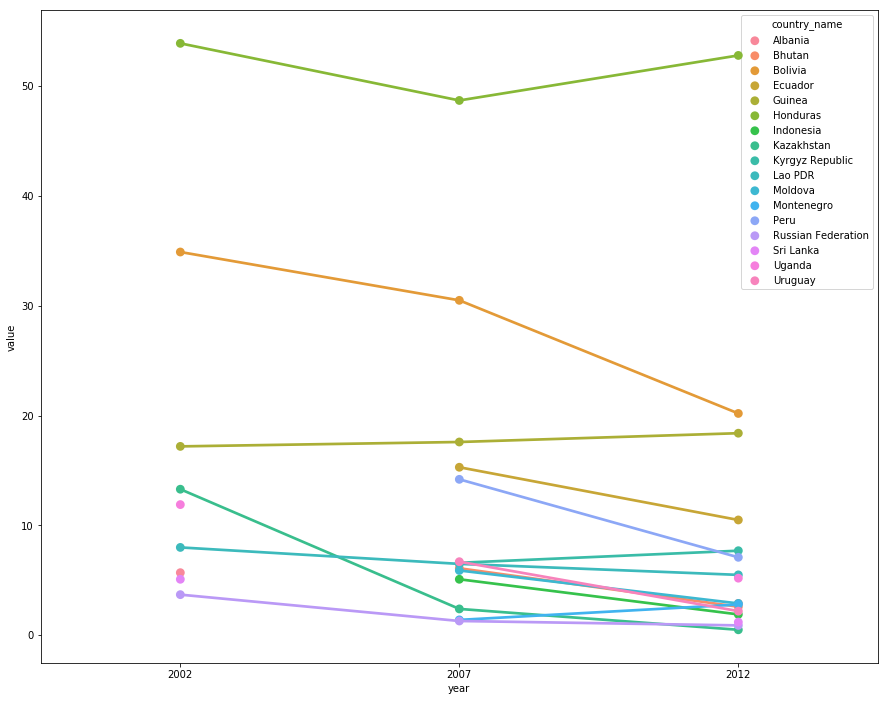

In [91]:
plt.figure(figsize=(15, 12))
sns.pointplot(x='year', y='value', hue='country_name', data=df_final);

The countries that have data for this index seem to be poorer countries. 

Is there any indicator that has a wider spread of countries that have collected data?

What about:
- Income of highest 10%: SI.DST.10TH.10
- Income of lowest 10%: SI.DST.FRST.10

In [93]:
params = {'format': 'json', 'per_page': '1000', 'date': '1990:2017'}

for data_code, file_name in zip(['SI.DST.10TH.10', 'SI.DST.FRST.10'], ['highest_10', 'lowest_10']):
    full_query(data_code, params, 'data/' + file_name)

In [30]:
df_highest = extract_data('data/highest_10')
df_highest.head()

,country,code,year,value
0,Arab World,1A,2018,NaN
1,Arab World,1A,2017,NaN
2,Arab World,1A,2016,NaN
3,Arab World,1A,2015,NaN
4,Arab World,1A,2014,NaN


In [31]:
df_lowest = extract_data('data/lowest_10')
df_lowest.head()

,country,code,year,value
0,Arab World,1A,2018,NaN
1,Arab World,1A,2017,NaN
2,Arab World,1A,2016,NaN
3,Arab World,1A,2015,NaN
4,Arab World,1A,2014,NaN


Let's drop countries with missing values.

In [32]:
df_h_notna = df_highest.dropna()
df_h_notna.shape

(1406, 4)

In [33]:
df_l_notna = df_lowest.dropna()
df_l_notna.shape

(1405, 4)

The number of rows in each dataset match. This suggests that the countries and years that have data for these indicators are the same.

In [103]:
(df_l_notna.drop('value', axis=1) == df_h_notna.drop('value', axis=1)).sum()

country_id      1304
country_name    1304
year            1304
dtype: int64

Yes, this is correct, all cells in all rows for both df, apart from value are equal.

What years have the most data?

In [104]:
df_l_notna.groupby('year')['year'].count().sort_values(ascending=False)

year
2010    82
2012    76
2011    75
2009    74
2005    72
2013    72
2006    72
2014    71
2008    71
2007    71
2004    68
2015    67
2003    53
2002    44
1998    36
2001    34
2000    33
2016    29
1996    29
1999    27
1992    26
1995    24
1997    22
1994    22
1993    22
1990    15
1991    14
2017     3
Name: year, dtype: int64

Looks like we have decent data from 2005 to 2015.

Let's do a quick plot of the distribution of the two dataframes.

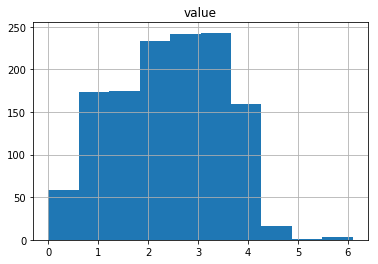

In [105]:
df_l_notna.hist();

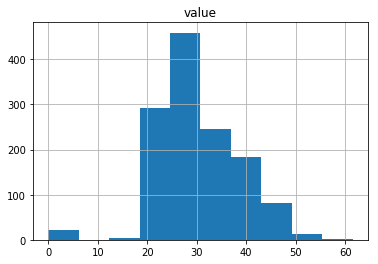

In [106]:
df_h_notna.hist();

The unit here is income share, the income share of the lowest 10% ranges from just over 0% to around 6%, while the income share for the highest 10% typically ranges from 20% to 60%. 

We can join these datasets to combine the data for income share and then melt for plotting.

In [36]:
df_income_full.head()

,country,code_x,year,value_x,code_y,value_y
0,Albania,AL,2012,3.7,AL,22.9
1,Albania,AL,2008,3.7,AL,24.5
2,Albania,AL,2005,3.5,AL,24.3
3,Albania,AL,2002,3.5,AL,25.4
4,Albania,AL,1996,3.9,AL,21.2


In [49]:
df_income_full = df_l_notna.merge(df_h_notna, on=['country', 'year'])
df_income_full.drop(['code_y'], axis=1, inplace=True)
df_income_full.rename(columns={'value_x': 'lowest_10', 'value_y': 'highest_10', 'code_x': 'code'}, inplace=True)
df_income_full.head()

,country,code,year,lowest_10,highest_10
0,Albania,AL,2012,3.7,22.9
1,Albania,AL,2008,3.7,24.5
2,Albania,AL,2005,3.5,24.3
3,Albania,AL,2002,3.5,25.4
4,Albania,AL,1996,3.9,21.2


Let's also create a column for the difference between the two.

In [43]:
df_income_full['difference'] = df_income_full.highest_10 - df_income_full.lowest_10

Let's filter for the years we are looking for and select countries that have data for at least 3 years. 

In [40]:
select_years = [str(x) for x in range(2005, 2019)]
df_income_years = df_income_full[df_income_full.year.isin(select_years)]

In [96]:
# Find countries with income for at least three years
df_income_years['missing'] = df_income_years['lowest_10'].isna()
country_missing = df_income_years.groupby('country')['missing'].sum()
select_countries = country_missing[country_missing <= 12].index.tolist()
print(select_countries)

['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia, The', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Korea, Rep.', 'Kosovo', 'Kyrgyz Republic', 'Lao PDR', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia

Interesting, the United States, Canada, and Australia are not in this list. Let's see what data they have.

In [116]:
df_income_full.query('country == "Australia"')

,country,year,lowest_10,highest_10,difference
51,Australia,2010,2.8,26.4,23.6
52,Australia,2008,2.8,27.4,24.6
53,Australia,2003,2.7,25.1,22.4
54,Australia,2001,2.7,25.1,22.4
55,Australia,1995,2.9,24.6,21.7


In [117]:
df_income_full.query('country == "Canada"')

,country,year,lowest_10,highest_10,difference
199,Canada,2013,2.4,25.3,22.9
200,Canada,2010,2.7,25.7,23.0
201,Canada,2007,2.7,26.0,23.3
202,Canada,2004,2.6,25.6,23.0
203,Canada,2000,2.7,25.5,22.8
204,Canada,1998,2.7,25.3,22.6
205,Canada,1997,2.8,23.8,21.0
206,Canada,1994,2.9,23.6,20.7
207,Canada,1991,2.9,23.6,20.7


In [119]:
df_income_full.query('country == "United States"')

,country,year,lowest_10,highest_10,difference
1238,United States,2016,1.7,30.6,28.9
1239,United States,2013,1.7,30.1,28.4
1240,United States,2010,1.7,29.4,27.7
1241,United States,2007,1.7,30.5,28.8
1242,United States,2004,1.7,30.2,28.5
1243,United States,2000,1.9,30.4,28.5
1244,United States,1997,1.8,30.5,28.7
1245,United States,1994,1.8,29.7,27.9
1246,United States,1991,1.9,27.6,25.7


Perhaps less surprisingly, the United States and Canada have data for most of the same years since 2000. Australia has very different years. All have below the threshold of 7 that was used. Let's update the threshold to 3.

It would be good to compare the countries with the highest difference to the countries with the lowest difference.

In [99]:
in_selected_countries = df_income_full.country.isin(select_countries)
df_country_diffs = df_income_full[in_selected_countries].copy()
df_country_diffs['difference'] = df_country_diffs['highest_10'] - df_country_diffs['lowest_10']
df_country_diffs = df_country_diffs.groupby('country')['difference']\
.mean().reset_index().sort_values(by='difference')
df_country_diffs

,country,difference
125,Slovenia,17.069231
124,Slovak Republic,18.284615
133,Sweden,18.338462
36,Denmark,18.423077
35,Czech Republic,18.671429
106,Norway,18.707692
46,Finland,18.853846
145,Ukraine,18.936842
9,Belarus,18.985000
10,Belgium,19.400000


Let's look at three different groupings - the highest and largest 10 (which can change over time), and the countries in the [G10](https://en.wikipedia.org/wiki/Group_of_Ten_(economics).

In [100]:
smallest_10 = df_country_diffs.head(10)['country']
largest_10 = df_country_diffs.tail(10)['country']
g10 = ['Belgium', 'Canada', 'France', 'Germany', 'Italy',
       'Japan', 'Netherlands', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']

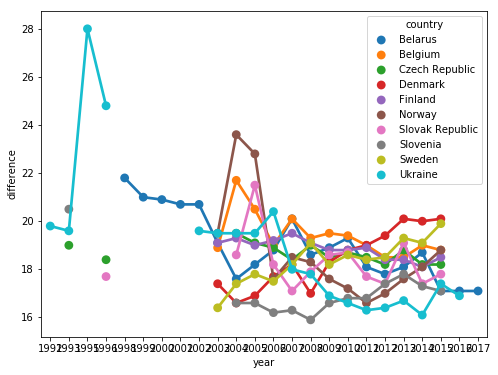

In [102]:
df_income_full['difference'] = df_income_full['highest_10'] - df_income_full['lowest_10']
in_smallest_10 = df_income_full.country.isin(smallest_10)

plt.figure(figsize=(8, 6))
sns.pointplot(x='year', y='difference', hue='country', data=df_income_full[in_smallest_10]);

When can see that for countries with the smallest difference that they have remained relatively stable. 

Let's move to plotting with plotly. To do so I need to change the country code to one that plotly recognizes.

In [47]:
def convert_country_code(data_df):
    """Adds 3 letter country code to dataframe with 2 letter country code."""
    country_df = pd.read_csv('data/country_map.txt', sep='\t')
    df = data_df.merge(country_df, left_on='code', right_on='2let')

    return df

In [103]:
df_final = df_income_full[in_selected_countries].copy()
df_final = convert_country_code(df_final)
df_2013 = df_final.query('year == "2013"').copy()
df_2013.dropna(inplace=True)

In [104]:
graph_one = [dict(
        type = 'choropleth',
        locations = df_2013['3let'],
        z = df_2013['difference'],
        text = df_2013['country'],
        colorscale = 'Viridis',
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            title = 'Difference in <br>Share of Income<br>(%)'),
    )]

layout_one = dict(
        margin = dict(
            l = 30,
            r = 10, 
            b = 0,
            t = 10,
            pad = 4
        ),
        geo = dict(
            # https://community.plot.ly/t/how-to-change-colors-for-na-values-to-gray-in-a-choropleth-map/15746/4
            landcolor = 'lightgray',
            showland = True,
            showcountries = True,
            countrycolor = 'gray',
            countrywidth = 0.5,
            showframe = False,
            showcoastlines = False,
            projection = dict(
                type = 'mercator'
            )
        )
    )

In [105]:
plotly.offline.init_notebook_mode(connected=True)
fig = go.Figure(data=graph_one, layout=layout_one)
plotly.offline.plot(fig)

'temp-plot.html'

In [106]:
selected_years = [str(x) for x in range(2000, 2019)]
df_years = df_final[df_final.year.isin(selected_years)]

average_diff = df_years.groupby('country')['difference'].mean().reset_index()\
        .sort_values(by='difference')
worst_6_countries = average_diff.country[-6:].tolist()
worst_6_countries.sort()

graph_two = []

for country in worst_6_countries:
        x_val = df_years[df_years['country'] == country].year.tolist()
        y_val = df_years[df_years['country'] == country].difference.tolist()
        graph_two.append(
            go.Scatter(x=x_val, 
                       y=y_val, 
                       mode='lines+markers', 
                       marker = dict(
                           size=2.25,
                       ),
                       name=country)
        )
    
layout_two = dict(
        title = 'Highest Income Inequality',
        xaxis = dict(
            title = 'Year',
            dtick = 5
        ),
        yaxis = dict(
            title = 'Difference in Income Share (%)'
        ),
        hovermode = 'closest',
    )

In [107]:
plotly.offline.init_notebook_mode(connected=True)
fig = go.Figure(data=graph_two, layout=layout_two)
plotly.offline.plot(fig)

'temp-plot.html'